# SECOM Dataset - EDA

Quick look at the dataset before building the model. Main things to figure out:
- How imbalanced are the classes?
- How bad is the missing data?
- Which features are mostly empty and should be dropped?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../data/uci-secom.csv')
print(f'Shape: {df.shape}')
df.head()

Shape: (1567, 592)


,Time,0,1,2,3,4,5,6,7,8,...,581,582,583,584,585,586,587,588,589,Pass/Fail
0,2008-07-19 11:55:00,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,...,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,-1
1,2008-07-19 12:32:00,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,...,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,-1
2,2008-07-19 13:17:00,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,...,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1
3,2008-07-19 14:43:00,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,...,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,-1
4,2008-07-19 15:22:00,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,...,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,-1


In [3]:
df.dtypes.value_counts()

float64    590
object       1
int64        1
Name: count, dtype: int64

## Class distribution

Labels are -1 (pass) and 1 (fail). Expecting heavy imbalance.

Pass/Fail
-1    1463
 1     104
Name: count, dtype: int64

Imbalance ratio: 14.1:1 (pass:fail)


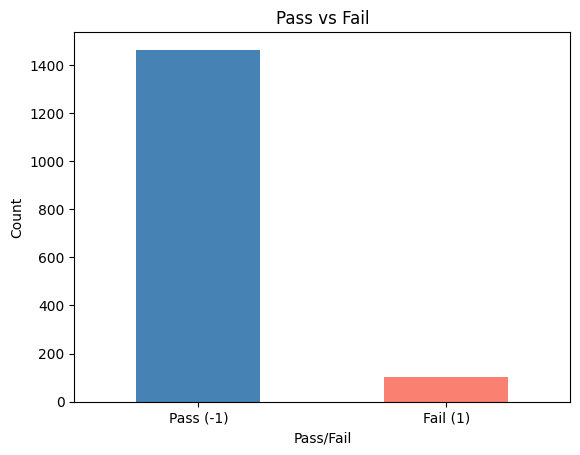

In [4]:
label_counts = df['Pass/Fail'].value_counts()
print(label_counts)
print(f'\nImbalance ratio: {label_counts[-1] / label_counts[1]:.1f}:1 (pass:fail)')

label_counts.plot(kind='bar', color=['steelblue', 'salmon'])
plt.title('Pass vs Fail')
plt.xticks([0, 1], ['Pass (-1)', 'Fail (1)'], rotation=0)
plt.ylabel('Count')
plt.show()

## Missing values

SECOM is known for having tons of NaNs. Need to figure out which columns are mostly empty so we can drop them.

In [5]:
# drop non-feature columns for this analysis
features = df.drop(columns=['Time', 'Pass/Fail'])

missing_pct = (features.isnull().sum() / len(features)) * 100
print(f'Total features: {len(missing_pct)}')
print(f'Features with any missing: {(missing_pct > 0).sum()}')
print(f'Features with >50% missing: {(missing_pct > 50).sum()}')
print(f'Features with zero missing: {(missing_pct == 0).sum()}')

Total features: 590
Features with any missing: 538
Features with >50% missing: 28
Features with zero missing: 52


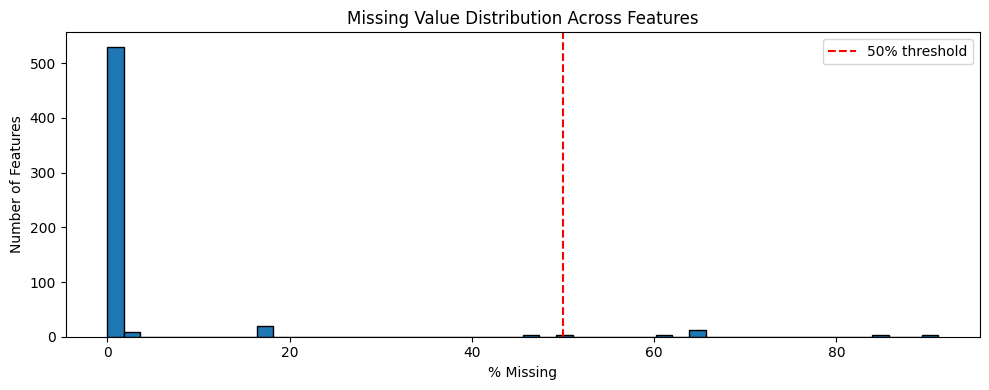

In [6]:
plt.figure(figsize=(10, 4))
plt.hist(missing_pct, bins=50, edgecolor='black')
plt.xlabel('% Missing')
plt.ylabel('Number of Features')
plt.title('Missing Value Distribution Across Features')
plt.axvline(x=50, color='red', linestyle='--', label='50% threshold')
plt.legend()
plt.tight_layout()
plt.show()

# worst offenders
missing_pct.sort_values(ascending=False).head(15)

In [ ]:
## Preprocessing Demo
Showing the cleaning, scaling, and split that happens in the training pipeline.

In [ ]:
# drop features with >50% missing
threshold = 50
cols_to_drop = missing_pct[missing_pct > threshold].index.tolist()
df_clean = df.drop(columns=['Time'] + cols_to_drop)
print(f"Dropped {len(cols_to_drop)} columns with >{threshold}% missing")
print(f"Remaining features: {df_clean.shape[1] - 1}")  # minus the label column

In [ ]:
# impute remaining missing values with median
from sklearn.impute import SimpleImputer

X = df_clean.drop(columns=['Pass/Fail']).values
y = df_clean['Pass/Fail'].values

# convert labels from -1/1 to 0/1
y = np.where(y == -1, 0, y)

imputer = SimpleImputer(strategy='median')
X = imputer.fit_transform(X)
print(f"Missing values after imputation: {np.isnan(X).sum()}")

In [ ]:
# impute remaining missing values with median
from sklearn.impute import SimpleImputer

X = df_clean.drop(columns=['Pass/Fail']).values
y = df_clean['Pass/Fail'].values

# convert labels from -1/1 to 0/1
y = np.where(y == -1, 0, y)

imputer = SimpleImputer(strategy='median')
X = imputer.fit_transform(X)
print(f"Missing values after imputation: {np.isnan(X).sum()}")

In [ ]:
# standardize features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Before scaling - mean: {X.mean():.2f}, std: {X.std():.2f}")
print(f"After scaling  - mean: {X_scaled.mean():.4f}, std: {X_scaled.std():.4f}")

In [ ]:
# stratified train/test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Train set: {X_train.shape[0]} samples, defect rate: {y_train.mean():.3f}")
print(f"Test set:  {X_test.shape[0]} samples, defect rate: {y_test.mean():.3f}")
print(f"\nBoth ~{y.mean():.3f} - stratification preserved the ratio")